<a href="https://colab.research.google.com/github/ninaanic/FER-progi/blob/main/MuReD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q -U albumentations
!pip install scikit-multilearn
!pip install iterative-stratification

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.9/227.9 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 680.5/680.5 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 4.3 MB/s eta 0:00:00


In [3]:
data_path = '/content/drive/My Drive/Dataset/'
ctran_path = '/content/drive/My Drive/C-Tran-main'

import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import sys, json
import albumentations as ab
import albumentations.pytorch as abp

# Paths
images_path = os.path.join(data_path, 'images')
train_csv = os.path.join(data_path, 'train_data.csv')
test_csv = os.path.join(data_path, 'test_data.csv')

sys.path.append(ctran_path)

In [4]:
labels_df = pd.read_csv(train_csv)
print(labels_df.head())

             ID  DR  NORMAL  MH  ODC  TSLN  ARMD  DN  MYA  BRVO  ...  CRVO  \
0   aria_c_25_1   0       1   0    0     0     0   0    0     0  ...     0   
1    aria_c_7_2   0       1   0    0     0     0   0    0     0  ...     0   
2   aria_c_38_2   0       1   0    0     0     0   0    0     0  ...     0   
3    aria_c_2_8   0       1   0    0     0     0   0    0     0  ...     0   
4  aria_c_26_15   0       1   0    0     0     0   0    0     0  ...     0   

   CNV  RS  ODE  LS  CSR  HTR  ASR  CRS  OTHER  
0    0   0    0   0    0    0    0    0      0  
1    0   0    0   0    0    0    0    0      0  
2    0   0    0   0    0    0    0    0      0  
3    0   0    0   0    0    0    0    0      0  
4    0   0    0   0    0    0    0    0      0  

[5 rows x 21 columns]


In [5]:
all_files = os.listdir(ctran_path)


for file in all_files:
    print(file)

requirements.txt
Explainability.py
optim_schedule.py
run_epoch.py
train.sh
main.py
experiments.py
cam_vit.py
README.md
.gitignore
cam_ctran.py
cam_cnn.py
dataloaders
models
datasamplers
wrappers
resampling
utils
load_data.py
__pycache__
config_args.py


In [6]:
# TODO - make file for MURED dataset
ctran_script = os.path.join(ctran_path, 'main.py')
!python "{ctran_script}" --batch_size 16  --lr 0.00001 --optim 'adam' --layers 3 --backbone 'densenet' --dataset 'mured' --use_lmt --dataroot "{data_path}"

Labels: 20
Train Known: 100
Test Known:  0
densenet
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100% 110M/110M [00:00<00:00, 148MB/s]
ModuleList(
  (0-2): 3 x SelfAttnLayer(
    (transformer_layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=2208, out_features=2208, bias=True)
      )
      (linear1): Linear(in_features=2208, out_features=2208, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2208, out_features=2208, bias=True)
      (norm1): LayerNorm((2208,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((2208,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
)
results/mured.3layer.bsz_16.adam1e-05.lmt.unk_loss
======================== 1 =================

In [ ]:
import pickle
from pdb import set_trace as stop
from dataloaders.data_utils import get_unk_mask_indices,image_loader
from wrappers.transforms import Transforms as tw


class MuReDDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, labels, image_transform=None, known_labels=0, testing=False):

        self.img_dir = img_dir
        self.img_names = labels['ID'].values

        self.num_labels = 20
        self.known_labels = known_labels
        self.testing = testing

        self.labels = labels.iloc[:, 1:].values
        self.image_transform = image_transform
        self.epoch = 1

    def __getitem__(self, index):
        name = self.img_names[index]
        possible_extensions = ['.png', '.tif']
        img_path = None
        for ext in possible_extensions:
            possible_path = os.path.join(self.img_dir, name + ext)
            if os.path.exists(possible_path):
                img_path = possible_path
                break

        if img_path is None:
            raise FileNotFoundError(f"Image file for '{name}' not found in {self.images_path}")

        # Load image
        image = Image.open(img_path).convert('RGB')

        if self.image_transform:
            image = self.image_transform(image)
            image = image['image']

        print(image)


        labels = torch.Tensor(self.labels[index])

        unk_mask_indices = get_unk_mask_indices(image, self.testing, self.num_labels, self.known_labels, self.epoch)

        mask = labels.clone()
        mask.scatter_(0, torch.Tensor(unk_mask_indices).long(), -1)

        sample = {
            'image': image,
            'labels': labels,
            'mask': mask,
            'imageIDs': name,
        }

        #print(sample)

        return sample

    def __len__(self):
        return len(self.img_names)


data_root = data_path
IMG_SIZE = 228

img_path = os.path.join(data_root, 'images')
labels_train_path = os.path.join(data_root, 'train_data.csv')
labels_test_path = os.path.join(data_root, 'test_data.csv')

train_data = pd.read_csv(labels_train_path)
val_data = pd.read_csv(labels_test_path)

transform_train = tw(ab.Compose([
    # albumentations.RandomResizedCrop(image_size, image_size, scale=(0.85, 1), p=1),
    ab.Resize(IMG_SIZE, IMG_SIZE),
    ab.HorizontalFlip(p=0.5),
    ab.VerticalFlip(p=0.5),
    ab.Rotate(limit=30, p=0.5),
    ab.MedianBlur(blur_limit=7, p=0.3),
    ab.GaussNoise(var_limit=(0, 0.15 * 255), p=0.5),
    ab.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10, p=0.3),
    ab.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.3),
    ab.CoarseDropout(max_holes=5, max_height=20, max_width=20, p=0.5),
    ab.Normalize(),
    abp.transforms.ToTensorV2(),
]))

transform_val = tw(ab.Compose([
    ab.Resize(IMG_SIZE, IMG_SIZE),
    ab.Normalize(),
    abp.transforms.ToTensorV2(),
]))

train_dataset = MuReDDataset(img_dir=img_path, labels=train_data, image_transform=transform_train, known_labels=0, testing=False)

valid_dataset = MuReDDataset(img_dir=img_path, labels=val_data, image_transform=transform_val, known_labels=0, testing=True)


In [ ]:

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

tensor([[[-0.2856, -0.2513, -0.2171,  ..., -0.2342, -0.1828, -0.1486],
         [-0.3883, -0.3712, -0.3712,  ..., -0.2856, -0.1828, -0.0629],
         [-0.5596, -0.6281, -0.5424,  ..., -0.1999, -0.0116, -0.0629],
         ...,
         [-0.4054, -0.4054, -0.4054,  ...,  0.2624,  0.2624,  0.2453],
         [-0.3712, -0.4054, -0.3712,  ...,  0.2282,  0.3994,  0.2796],
         [-0.3027, -0.3027, -0.3541,  ...,  0.2624,  0.3138,  0.2967]],

        [[-1.5805, -1.5805, -1.5805,  ..., -1.1604, -1.1604, -1.1604],
         [-1.6331, -1.6681, -1.6681,  ..., -1.1954, -1.2829, -1.1429],
         [-1.6681, -1.7031, -1.6681,  ..., -1.1604, -1.0378, -1.1253],
         ...,
         [-1.6506, -1.6155, -1.6506,  ..., -1.3354, -1.2829, -1.2829],
         [-1.6331, -1.6856, -1.6155,  ..., -1.3004, -1.2654, -1.3179],
         [-1.6331, -1.6681, -1.6856,  ..., -1.3179, -1.3179, -1.3179]],

        [[-1.1073, -1.1596, -1.1073,  ..., -0.5147, -0.5321, -0.5670],
         [-1.0898, -1.2119, -1.2119,  ..., -0

tensor([[[ 0.0056, -0.0801, -0.0287,  ..., -0.0458, -0.0629, -0.0458],
         [ 0.0056,  0.0398,  0.0056,  ..., -0.0972, -0.0116, -0.0287],
         [-0.0458,  0.0227,  0.0056,  ...,  0.0398, -0.0287, -0.0801],
         ...,
         [-0.1314, -0.0801, -0.0801,  ..., -0.0972, -0.1657, -0.1143],
         [-0.1314, -0.0287, -0.1314,  ..., -0.1828, -0.1143, -0.1828],
         [-0.0458, -0.0458, -0.0801,  ..., -0.0801, -0.1657, -0.1999]],

        [[-0.9153, -0.9853, -0.8803,  ..., -0.5826, -0.7052, -0.7402],
         [-0.8627, -0.7927, -0.8627,  ..., -0.6352, -0.7227, -0.6877],
         [-0.8277, -0.8803, -0.8627,  ..., -0.5651, -0.6702, -0.7052],
         ...,
         [-1.0028, -0.9328, -0.8277,  ..., -0.8627, -0.8277, -0.8102],
         [-1.0028, -0.9153, -0.9678,  ..., -0.8627, -0.8102, -0.8452],
         [-0.9503, -0.8978, -0.8452,  ..., -0.9503, -0.8277, -0.8803]],

        [[-1.4384, -1.3513, -1.3861,  ..., -1.3339, -1.4384, -1.3687],
         [-1.4036, -1.3339, -1.3687,  ..., -1

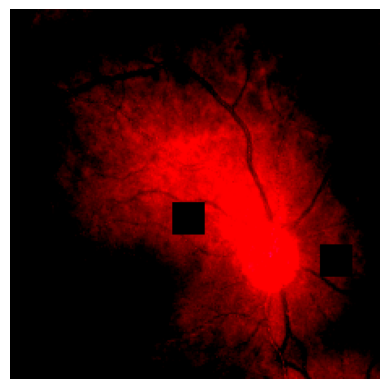

In [ ]:
batch = next(iter(train_loader))

# Extract images and labels from the batch dictionary
train_features = batch['image']
train_labels = batch['labels']
train_names = batch['imageIDs']

# Display the first image in the batch
img = train_features[0].squeeze()
label = train_labels[0]
name = train_names[0]

# Show the image and print the label
plt.imshow(img.permute(1, 2, 0))  # .permute to convert from (C, H, W) to (H, W, C)
plt.axis('off')
plt.show()
print(f"Name: {name}")
print(f"Label: {label}")